# Data preparation for modeling

In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
import graphviz
from sklearn import tree
import os
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm # seems to work only for scipy 1.2?
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('P:/recovery/pekan_projektit/Training/Datacamp_ml_for_marketing/telco_data.csv', sep = ',')

# Check data

In [ ]:
print(df.head())
print(df.dtypes)
print(df.nunique())
print(df.groupby('Churn').size() / df.shape[0]) # get ratio of obs in target

In [ ]:
df['Churn'] = df['Churn'].replace(['Yes', 'No'], [1, 0])

# Prepare data for ml

In [ ]:
# Store id and churn colnames
custid = ['customerID']
target = ['Churn']

In [ ]:
# Get categ vars with less than 5 categories
categorical = df.select_dtypes('object').nunique()
categorical = categorical[categorical < 5].index.tolist()
#categorical.remove('Churn') # remove target

numerical = df.select_dtypes('int64', 'float64').columns.to_list()
numerical.remove('Churn')

### Encode and scale variables 

In [ ]:
telco_raw = pd.get_dummies(df[categorical])
scaler = StandardScaler()
# Fit and transform the scaler on numerical columns
scaled_numerical = pd.DataFrame(scaler.fit_transform(df[numerical]), columns=numerical)

### Combine data

In [ ]:
#fin = df[categorical]
fina = telco_raw.join(scaled_numerical) # append scaled

### Split data to train and test

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(fina, df['Churn'], test_size=0.25)

In [ ]:
# Ensure training dataset has only 75% of original X data
print(train_X.shape[0] / fina.shape[0])
# Ensure testing dataset has only 25% of original X data
print(test_X.shape[0] / fina.shape[0])

## Fit a decision tree

In [ ]:
# Initialize the model with max_depth set at 5
mytree = DecisionTreeClassifier(max_depth = 5)
# Fit the model on the training data
treemodel = mytree.fit(train_X, train_Y)
# predict
pred_Y = treemodel.predict(test_X)

In [ ]:
# Measure model performance on testing data
score = mytree.score(test_X, test_Y)
print(score)

In [ ]:
# Initialize the Decision Tree
clf = DecisionTreeClassifier(max_depth = 7, 
               criterion = 'gini', 
               splitter  = 'best')
clf = clf.fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
# Print accuracy values
print("Training accuracy: ", np.round(clf.score(train_X, train_Y), 3)) 
print("Test accuracy: ", np.round(accuracy_score(test_Y, pred_Y), 3))

### Fit a logistic regression model

In [ ]:

logreg = LogisticRegression(C=1.0)
logreg = logreg.fit(train_X, train_Y)

In [ ]:
pred_train_Y = logreg.predict(train_X)
pred_test_Y = logreg.predict(test_X)

train_precision = precision_score(train_Y, pred_train_Y)
test_precision = precision_score(test_Y, pred_test_Y)
train_recall = round(recall_score(train_Y, pred_train_Y), 4)
test_recall = round(recall_score(test_Y, pred_test_Y), 4)

In [ ]:
print('Training precision: {} Training recall: {}'  .format(train_precision, train_recall))

In [ ]:
print('Testing precision: {} Testing recall: {}' .format(test_precision, test_recall))

### Logistic regression with regularization and feature selection

In [ ]:
logreg = LogisticRegression(penalty='l1', C=0.025, solver='liblinear') # tune C for optimal value
logreg.fit(train_X, train_Y)
pred_test_Y = logreg.predict(test_X)

In [ ]:
print('Test accuracy: ', round(accuracy_score(test_Y, pred_test_Y), 4))

### Tuning L1 regularization

In [ ]:
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))
l1_metrics[:,0] = C

In [ ]:
for index in range(0, len(C)):
    logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')
    logreg.fit(train_X, train_Y)
    pred_test_Y = logreg.predict(test_X)
    l1_metrics[index, 1] = np.count_nonzero(logreg.coef_)
    l1_metrics[index, 2] = round(accuracy_score(test_Y, pred_test_Y), 4)
    l1_metrics[index, 3] = round(precision_score(test_Y, pred_test_Y), 4)
    l1_metrics[index, 4] = round(recall_score(test_Y, pred_test_Y), 4)
col_names = ['C', 'Non-Zero Coeffs', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(l1_metrics, columns = col_names))

# Predicting Churn with decision trees

In [ ]:
mytree = DecisionTreeClassifier()
treemodel= mytree.fit(train_X, train_Y)

In [ ]:
pred_train_Y = treemodel.predict(train_X)
pred_test_Y = treemodel.predict(test_X)
train_accuracy = accuracy_score(train_Y, pred_train_Y)
test_accuracy = accuracy_score(test_Y, pred_test_Y)
print('Training accuracy: ', round(train_accuracy, 4))
print('Test accuracy: ', round(test_accuracy, 4))

### Precision and recall

In [ ]:
train_precision = round(precision_score(train_Y, pred_train_Y), 4)
test_precision = round(precision_score(test_Y, pred_test_Y), 4)

train_recall = round(recall_score(train_Y, pred_train_Y), 4) 
rest_recall = round(recall_score(test_Y, pred_test_Y), 4)

print('Train precision: {}, Training recall: {}' .format(train_precision, train_recall))
print('Test precision: {}, Test recall: {}' .format(test_precision, test_recall))

### Tuning tree depth parameter

In [ ]:
# tune in a same way we did C value for logistic regression

depth_list = list(range(2, 15)) # create a list of max depth candidates between 2 and 14
# create a numpy array with zeros and store list as the first col
depth_tuning = np.zeros((len(depth_list), 4)) 
depth_tuning[:, 0] = depth_list
for index in range(len(depth_list)):
    mytree = DecisionTreeClassifier(max_depth=depth_list[index])
     # iterate through depth values and fit a decision tree for each
    mytree.fit(train_X, train_Y)
    pred_test_Y = mytree.predict(test_X)
    # calculate scores for testing data and store in numpy array
    depth_tuning[index, 1] = round(accuracy_score(test_Y, pred_test_Y), 4) 
    depth_tuning[index, 2] = round(precision_score(test_Y, pred_test_Y), 4)
    depth_tuning[index, 3] = round(recall_score(test_Y, pred_test_Y), 4)
col_names = ['Max_Depth','Accuracy','Precision','Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))


# Identify churn

### Interpreting decision trees

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/graphviz-2.38/release/bin/' # add graphviz to path

In [ ]:
exported = tree.export_graphviz(
    decision_tree = mytree,
    out_file = None,
    feature_names=cols,
    precision=1,
    class_names=['Not Churn', 'Churn'],
    filled=True)
graph = graphviz.Source(exported)
#display(graph)

### Interpreting logistic regression results

In [ ]:
#logreg.coef_
# difficulty is that the results do not have colnames
# and that the results are in log odds scale, which is difficult to interpret
# we need to turn this into a df and take exponent of log odds
coefficients = pd.concat([pd.DataFrame(train_X.columns),   # predictors
                         pd.DataFrame(np.transpose(logreg.coef_))],
                         axis = 1)
coefficients.columns = ['Feature', 'Coefficient']
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coeffs = coefficients[coefficients['Coefficient'] != 0] # get nonzero coeffs
print(coeffs.sort_values('Coefficient'))

# does not account for statistical significance
# values less than one decrease the odds
# values less than one increase the odds

# Customer lifetime value (CLV)

In [2]:
cohort_counts = pd.read_csv('P:/recovery/pekan_projektit/Training/Datacamp_ml_for_marketing/cohort_counts.csv', 
                            sep=';', index_col = 0)

In [3]:
cohort_sizes = cohort_counts.iloc[:,0] # Extract cohort sizes 
retention = cohort_counts.divide(cohort_sizes, axis = 0) # Calculate retention by counts/cohort sizes
# Calculate churn
churn = 1 - retention

In [4]:
# Calculate the mean retention rate
retention_rate = round(retention.iloc[:,1:].mean().mean(), 2)
churn_rate = round(churn.iloc[:,1:].mean().mean(), 2)
print('Retention rate: {}, Churn rate: {}' .format(retention_rate, churn_rate))

Retention rate: 0.24, Churn rate: 0.76


### Basic CLV at the customer level

In [5]:
online = pd.read_excel('P:/recovery/pekan_projektit/Training/Datacamp_ml_for_marketing/OnlineRetail.xlsx')

In [8]:
online['InvoiceDay'] = online['InvoiceDate'].dt.day
online['InvoiceMonth'] = online['InvoiceDate'].dt.month
online['InvoiceYear'] = online['InvoiceDate'].dt.year
online['InvoiceYearMonth'] = online['InvoiceYear'].astype(str) + '-' + online['InvoiceMonth'].astype(str)
online['InvoiceYearMonthDay'] = online['InvoiceYear'].astype(str) + '-' + online['InvoiceMonth'].astype(str) + '-' + online['InvoiceDay'].astype(str)
online['TotalSum'] = online['UnitPrice'] * online['Quantity']

In [9]:
monthly_revenue_grp = online.groupby(['CustomerID', 'InvoiceMonth'])['TotalSum'].sum()
monthly_revenue_avg = np.mean(monthly_revenue_grp)

In [10]:
# basic CLV
lifespan_months = 36 # Define lifespan 
clv_basic = round(monthly_revenue_avg * lifespan_months, 2)
print('Average basic CLV is: {} USD' .format(clv_basic))

Average basic CLV is: 22273.75 USD


### Granular CLV at the level of invoice

In [11]:
# Calculate average revenue per invoice
revenue_per_purchase = online.groupby(['InvoiceNo'])['TotalSum'].mean().mean()
# Avg number of unique invoices per month
frequency_per_month = online.groupby(['CustomerID', 'InvoiceMonth'])['InvoiceNo'].nunique().mean()
lifespan_months = 36 # Define lifespan 
# Calculate granular CLV
clv_granular = revenue_per_purchase * frequency_per_month * lifespan_months
print('Average granular CLV is: {} USD' .format(clv_granular))

Average granular CLV is: 1206.5748509417976 USD


### Calculate traditional CLV

In [12]:
# Calculate monthly spend per customer
monthly_revenue = online.groupby(['CustomerID', 'InvoiceMonth'])['TotalSum'].sum().mean()

# Calculate average monthly retention rate
retention_rate = round(retention.iloc[:,1:].mean().mean(), 2)
churn_rate = 1 - retention_rate # avg monthly churn rate
clv_traditional = round(monthly_revenue * (retention_rate / churn_rate), 2)
print('Average traditional CLV is {} USD at {} % retention rate' .format(clv_traditional, retention_rate *100))

Average traditional CLV is 195.38 USD at 24.0 % retention rate


## Preparing data for predicting purchases and CLV

### RFM

In [13]:
online.groupby('InvoiceMonth').size()
#online.groupby('InvoiceYear').size()
#online.groupby('InvoiceYearMonthDay').size()

InvoiceMonth
1     35147
2     27707
3     36748
4     29916
5     37030
6     36874
7     39518
8     35284
9     50226
10    60742
11    84711
12    68006
dtype: int64

In [14]:
# use last months as a period for target variable
# exlude it first
online_X = online[online['InvoiceMonth'] != 12]

In [15]:
NOW = datetime(2011, 1, 1)

In [16]:
features = online_X.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': pd.Series.nunique,
    'TotalSum': np.sum,
    'Quantity': ['mean', 'sum']
}).reset_index()

features.columns = ['CustomerID', 'recency', 'frequency', 'monatary', 
                   'quantity_avg', 'quantity_total']

### Calculating the target variable

In [17]:
# Pivot table with monthly actions per customer
cust_month_tx = pd.pivot_table(data=online, index=['CustomerID'],
                               values='InvoiceNo',
                               columns='InvoiceYearMonth',
                               aggfunc=pd.Series.nunique, fill_value=0)
print(cust_month_tx.head())

InvoiceYearMonth  2010-12  2011-1  2011-10  2011-11  2011-12  2011-2  2011-3  \
CustomerID                                                                     
12346.0                 0       2        0        0        0       0       0   
12347.0                 1       1        1        0        1       0       0   
12348.0                 1       1        0        0        0       0       0   
12349.0                 0       0        0        1        0       0       0   
12350.0                 0       0        0        0        0       1       0   

InvoiceYearMonth  2011-4  2011-5  2011-6  2011-7  2011-8  2011-9  
CustomerID                                                        
12346.0                0       0       0       0       0       0  
12347.0                1       0       1       0       1       0  
12348.0                1       0       0       0       0       1  
12349.0                0       0       0       0       0       0  
12350.0                0       0     

### finalize data for training and testing

In [18]:
target = ['2011-11']
custid = ['CustomerID']
Y = cust_month_tx[target] # get target
Y = Y[Y.index.isin(features['CustomerID'])]

cols = [col for col in features.columns if col not in custid] # features, exlude customerid
X = features[cols]

In [19]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=99
                                                   )

# Build a linear logistic model

In [20]:
linreg = LinearRegression()
linreg.fit(train_X, train_Y)
train_pred_Y = linreg.predict(train_X)
test_pred_Y = linreg.predict(test_X)

In [21]:
rmse_train = round(np.square(mean_squared_error(train_Y, train_pred_Y)), 2)
mse_train = round(mean_squared_error(train_Y, train_pred_Y), 2)

rmse_test = round(np.square(mean_squared_error(test_Y, test_pred_Y)), 2)
mse_test = round(mean_squared_error(test_Y, test_pred_Y), 2)

In [22]:
print('RMSE train: {}, MSE train: {}\n RMSE test: {} MSE test: {}' .format(rmse_train, mse_train, rmse_test, mse_test))

RMSE train: 0.87, MSE train: 0.93
 RMSE test: 0.75 MSE test: 0.87


In [30]:
train_Y = np.array(train_Y)
olsreg = sm.OLS(train_Y, train_X)
olsreg = olsreg.fit()
print(olsreg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.662
Method:                 Least Squares   F-statistic:                              1231.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):                        0.00
Time:                        11:51:23   Log-Likelihood:                         -4468.8
No. Observations:                3147   AIC:                                      8948.
Df Residuals:                    3142   BIC:                                      8978.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

# Customer and product segmentation basics

In [32]:
wholesale = pd.read_csv('P:/recovery/pekan_projektit/Training/Datacamp_ml_for_marketing/wholesale.csv', 
                    sep = ',')

In [52]:
wholesale.agg(['mean', 'std']).round(2)
wholesale = wholesale.drop(['Channel', 'Region'], axis = 1)

In [54]:
averages = wholesale.mean()
stdev = wholesale.std()
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

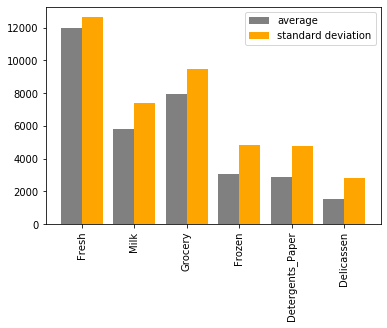

In [55]:
plt.bar(x_ix-0.2, averages, color='gray', label='average', width=0.4)
plt.bar(x_ix+0.2, stdev, color='orange', label='standard deviation', width=0.4)
plt.xticks(x_ix, x_names, rotation=90)
plt.legend()
plt.show()

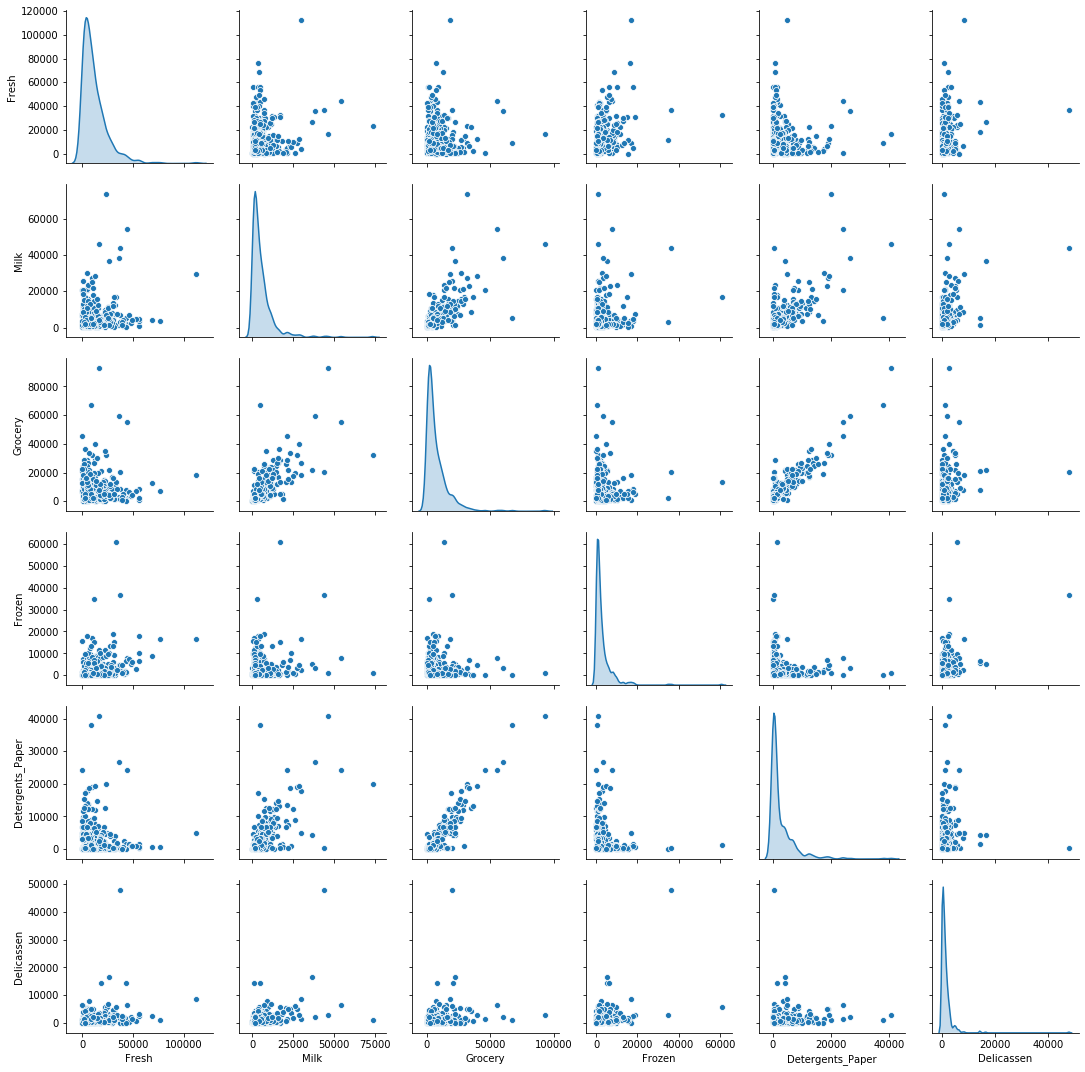

In [58]:
sns.pairplot(wholesale, diag_kind='kde') # kernel density estimates
plt.show()

### Data preparation for segmentation

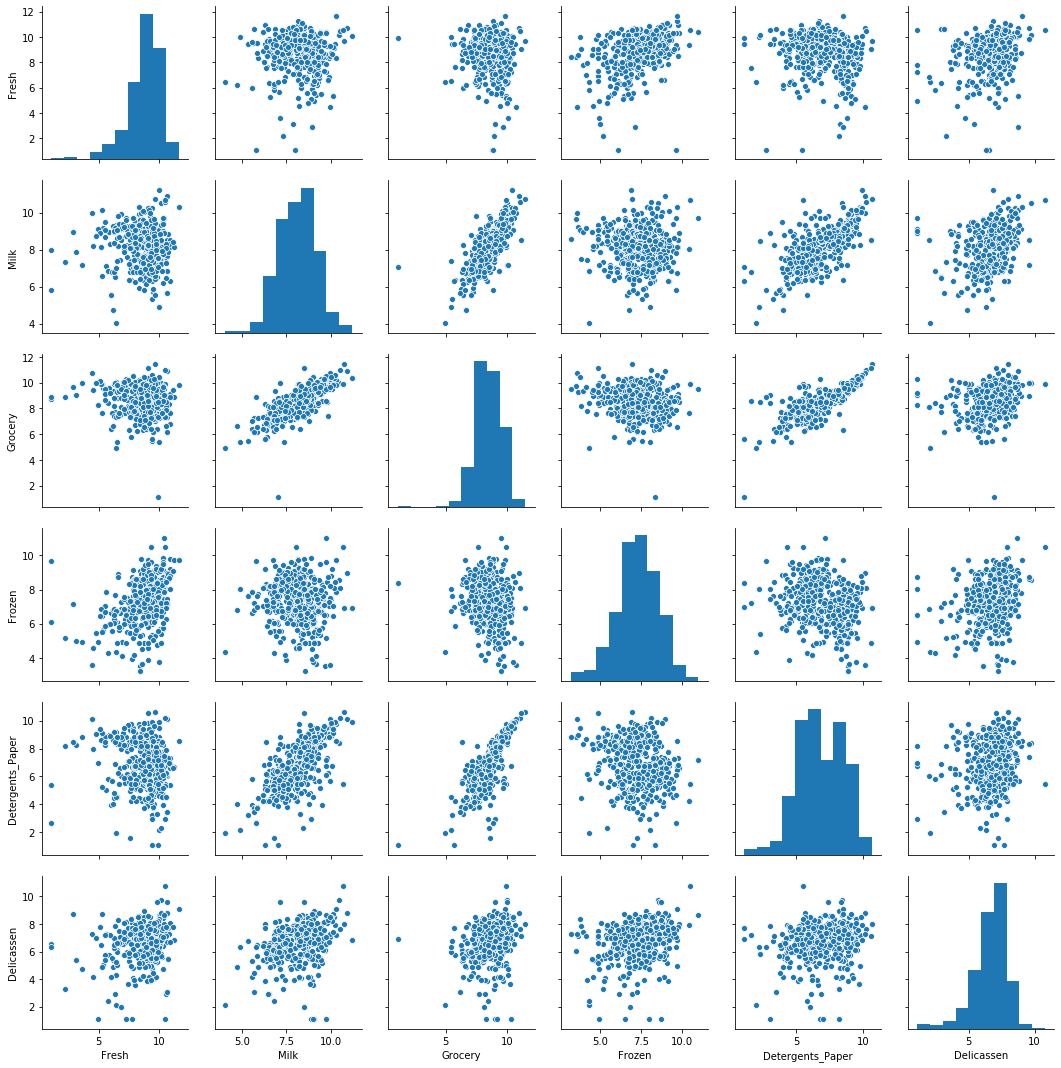

In [59]:
wholesale_log = np.log(wholesale)
sns.pairplot(wholesale_log)
plt.show()

In [60]:
from scipy import stats

In [61]:
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x) # underscore means we only care about the first object
    return x_boxcox
    

In [62]:
wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)

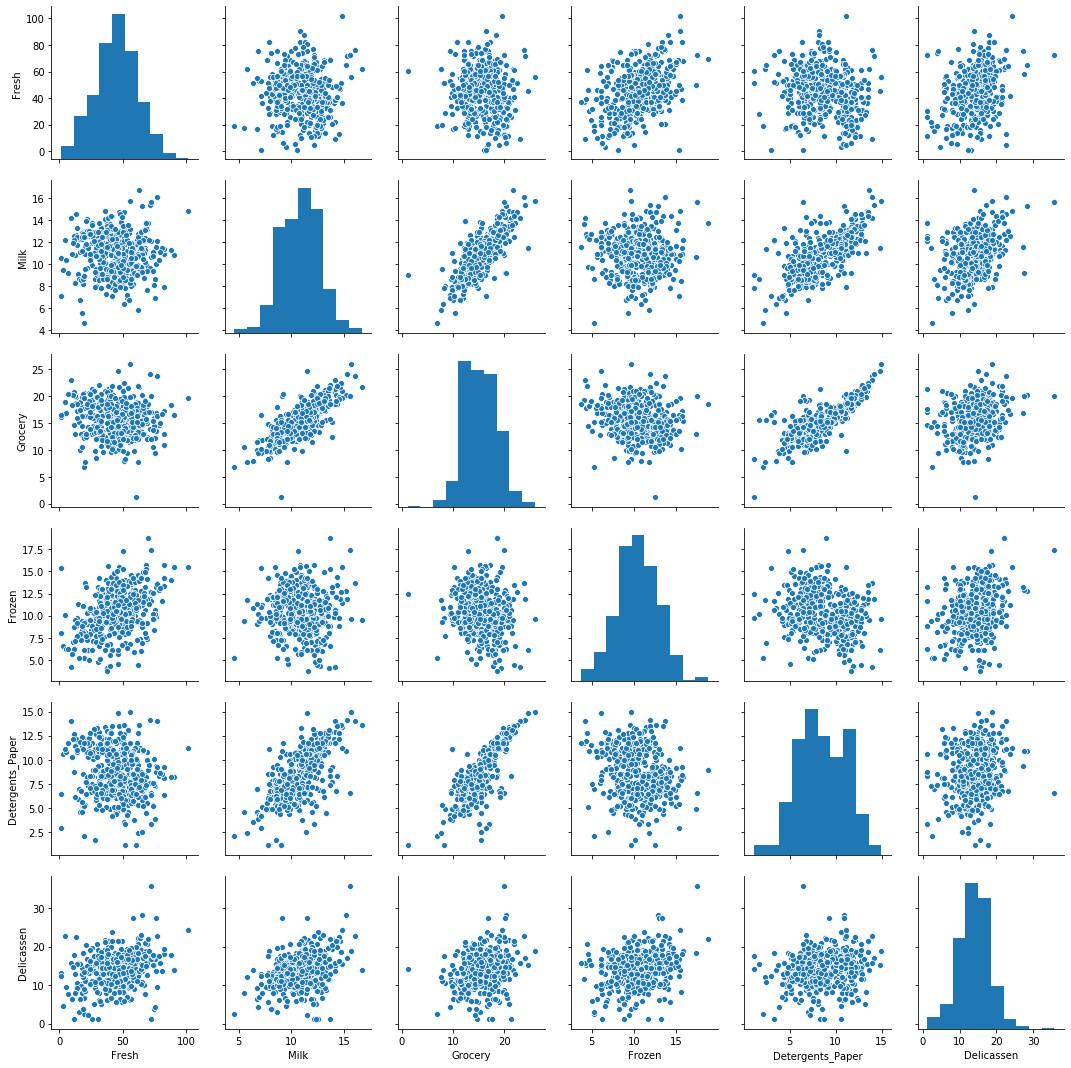

In [63]:
sns.pairplot(wholesale_boxcox)
plt.show()

### Scale data

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(wholesale_boxcox)
wholesale_scaled = scaler.transform(wholesale_boxcox)
wholesale_scaled_df = pd.DataFrame(wholesale_scaled, 
                                  index=wholesale_boxcox.index,
                                  columns=wholesale_boxcox.columns)

wholesale_scaled_df.agg(['mean', 'std']).round(2) # check this worked

### Build segmentations

### Kmeans

In [73]:
from sklearn.cluster import KMeans

In [75]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(wholesale_scaled_df)
wholesale_kmeans4 = wholesale.assign(segment=kmeans.labels_)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,segment
0,12669,9656,7561,214,2674,1338,3
1,7057,9810,9568,1762,3293,1776,3
2,6353,8808,7684,2405,3516,7844,3
3,13265,1196,4221,6404,507,1788,1
4,22615,5410,7198,3915,1777,5185,1
...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,1
436,39228,1431,764,4510,93,2346,1
437,14531,15488,30243,437,14841,1867,3
438,10290,1981,2232,1038,168,2125,2


### NMF (Nonnegative matrix factorization)

In [77]:
from sklearn.decomposition import NMF

In [119]:
nmf = NMF(4)
nmf.fit(wholesale)
components = pd.DataFrame(nmf.components_, columns=wholesale.columns)

In [121]:
segment_weights = pd.DataFrame(nmf.transform(wholesale), columns=components.index)
segment_weights.index = wholesale.index
wholesale_nmf4 = wholesale.assign(segment=segment_weights.idxmax(axis=1))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,segment
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,0
...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,0
436,39228,1431,764,4510,93,2346,0
437,14531,15488,30243,437,14841,1867,1
438,10290,1981,2232,1038,168,2125,0


### Number of segments?

In [114]:
# elbow criterion
sse = {}
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, random_state=333).fit(wholesale_scaled_df)
    #kmeans.fit(wholesale_scaled_df)
    sse[i] = kmeans.inertia_


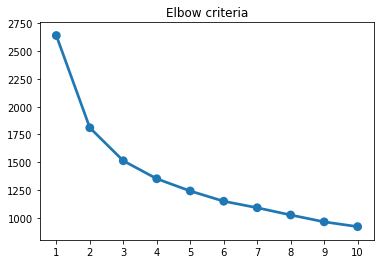

In [115]:
plt.title('Elbow criteria')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

## Visualise results

In [117]:
kmeans_4_averages = wholesale_kmeans4.groupby(['segment']).mean().round(0)
print(kmeans_4_averages)

           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0         3618.0   6645.0  11296.0   703.0            4675.0       576.0
1        26312.0   5489.0   5228.0  8342.0             830.0      3212.0
2        10229.0   1891.0   2500.0  2403.0             449.0       741.0
3        10453.0  12717.0  17723.0  1940.0            7684.0      2394.0


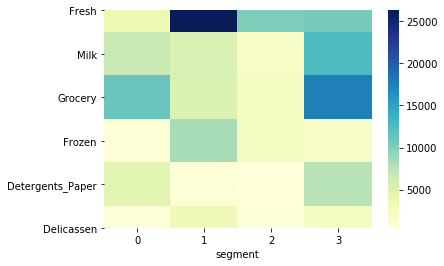

In [118]:
sns.heatmap(kmeans_4_averages.T, cmap='YlGnBu')

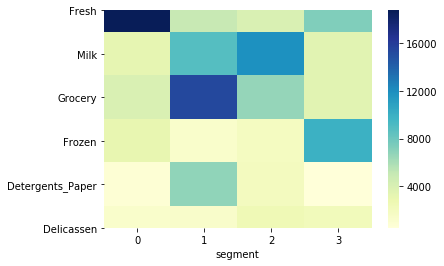

In [123]:
nmf4_averages = wholesale_nmf4.groupby(['segment']).mean().round()
sns.heatmap(nmf4_averages.T, cmap='YlGnBu')